<a href="https://colab.research.google.com/github/MeatHub/Team-Assignment---MobileNet/blob/main/1_MobileNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 모든 라이브러리 Import
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from google.colab import drive
import shutil
import numpy as np
from collections import Counter

In [ ]:
# ==========================================
# 1. 구글 드라이브 마운트
# ==========================================
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 현재 장치: {device}")

Mounted at /content/drive
🚀 현재 장치: cuda


In [ ]:
# ==========================================
# 2. 데이터 압축 해제
# ==========================================
zip_path = '/content/drive/MyDrive/data/plant.zip'
extract_path = '/content/unzipped_data'

if os.path.exists(zip_path):
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)

    print(f"📦 '{zip_path}' 압축을 푸는 중... (잠시만 기다려주세요)")
    result = os.system(f'unzip -q -o "{zip_path}" -d "{extract_path}"')

    if result == 0:
        print("✅ 압축 해제 성공!")
    else:
        print("❌ 압축 해제 실패! zip 파일이 깨졌거나 경로가 이상합니다.")
else:
    print(f"❌ 에러: zip 파일을 찾을 수 없습니다. 경로를 확인해주세요: {zip_path}")

📦 '/content/drive/MyDrive/data/plant.zip' 압축을 푸는 중... (잠시만 기다려주세요)
✅ 압축 해제 성공!


In [ ]:
# ==========================================
# 3. 폴더 구조 확인
# ==========================================
print("\n🔍 [데이터 폴더 내부 구조 확인]")

if os.path.exists(extract_path):
    contents = os.listdir(extract_path)
    print(f"📂 '{extract_path}' 안에 있는 것들: {contents}")

    for item in contents:
        full_path = os.path.join(extract_path, item)
        if os.path.isdir(full_path):
            inner_contents = os.listdir(full_path)[:5]
            print(f"   ㄴ 📂 '{item}' 폴더 내부: {inner_contents} ...")

            if 'train' in inner_contents or item == 'train':
                print("      👉 [진단] 학습용 폴더(train)가 보입니다!")
else:
    print("❌ 압축 푼 폴더가 생성되지 않았습니다.")


🔍 [데이터 폴더 내부 구조 확인]
📂 '/content/unzipped_data' 안에 있는 것들: ['new plant diseases dataset(augmented)', 'test', 'New Plant Diseases Dataset(Augmented)']
   ㄴ 📂 'new plant diseases dataset(augmented)' 폴더 내부: ['New Plant Diseases Dataset(Augmented)'] ...
   ㄴ 📂 'test' 폴더 내부: ['test'] ...
   ㄴ 📂 'New Plant Diseases Dataset(Augmented)' 폴더 내부: ['New Plant Diseases Dataset(Augmented)'] ...


In [ ]:
# ==========================================
# 4. 데이터 경로 설정
# ==========================================
target_dir = os.path.join(extract_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')

if not os.path.exists(target_dir):
    target_dir = os.path.join(extract_path, 'new plant diseases dataset(augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')

print(f"\n📂 최종 학습 경로 확인: {target_dir}")



📂 최종 학습 경로 확인: /content/unzipped_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train


In [ ]:
# ==========================================
# 5. 데이터셋 로드 및 전처리
# ==========================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    full_dataset = datasets.ImageFolder(target_dir, transform=transform)
except FileNotFoundError:
    print("❌ 에러: 경로 설정이 여전히 틀렸습니다. 위의 '📂 안에 있는 것들' 목록을 다시 확인해주세요.")
    raise

class_names = full_dataset.classes

# 데이터 분할 (학습 80% : 검증 20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("\n" + "="*60)
print(f"📌 [데이터셋 정상 로드 성공!]")
print(f" - 클래스 개수: {len(class_names)}개")
print(f" - 클래스 목록(일부): {class_names[:5]} ...")
print(f" - 총 이미지: {len(full_dataset)}장")
print(f" - 학습 데이터: {train_size}장")
print(f" - 검증 데이터: {val_size}장")
print("="*60)


📌 [데이터셋 정상 로드 성공!]
 - 클래스 개수: 38개
 - 클래스 목록(일부): ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...
 - 총 이미지: 70295장
 - 학습 데이터: 56236장
 - 검증 데이터: 14059장



📊 [시각화] 클래스별 데이터 분포 확인 중...


/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3851569504.py:16: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

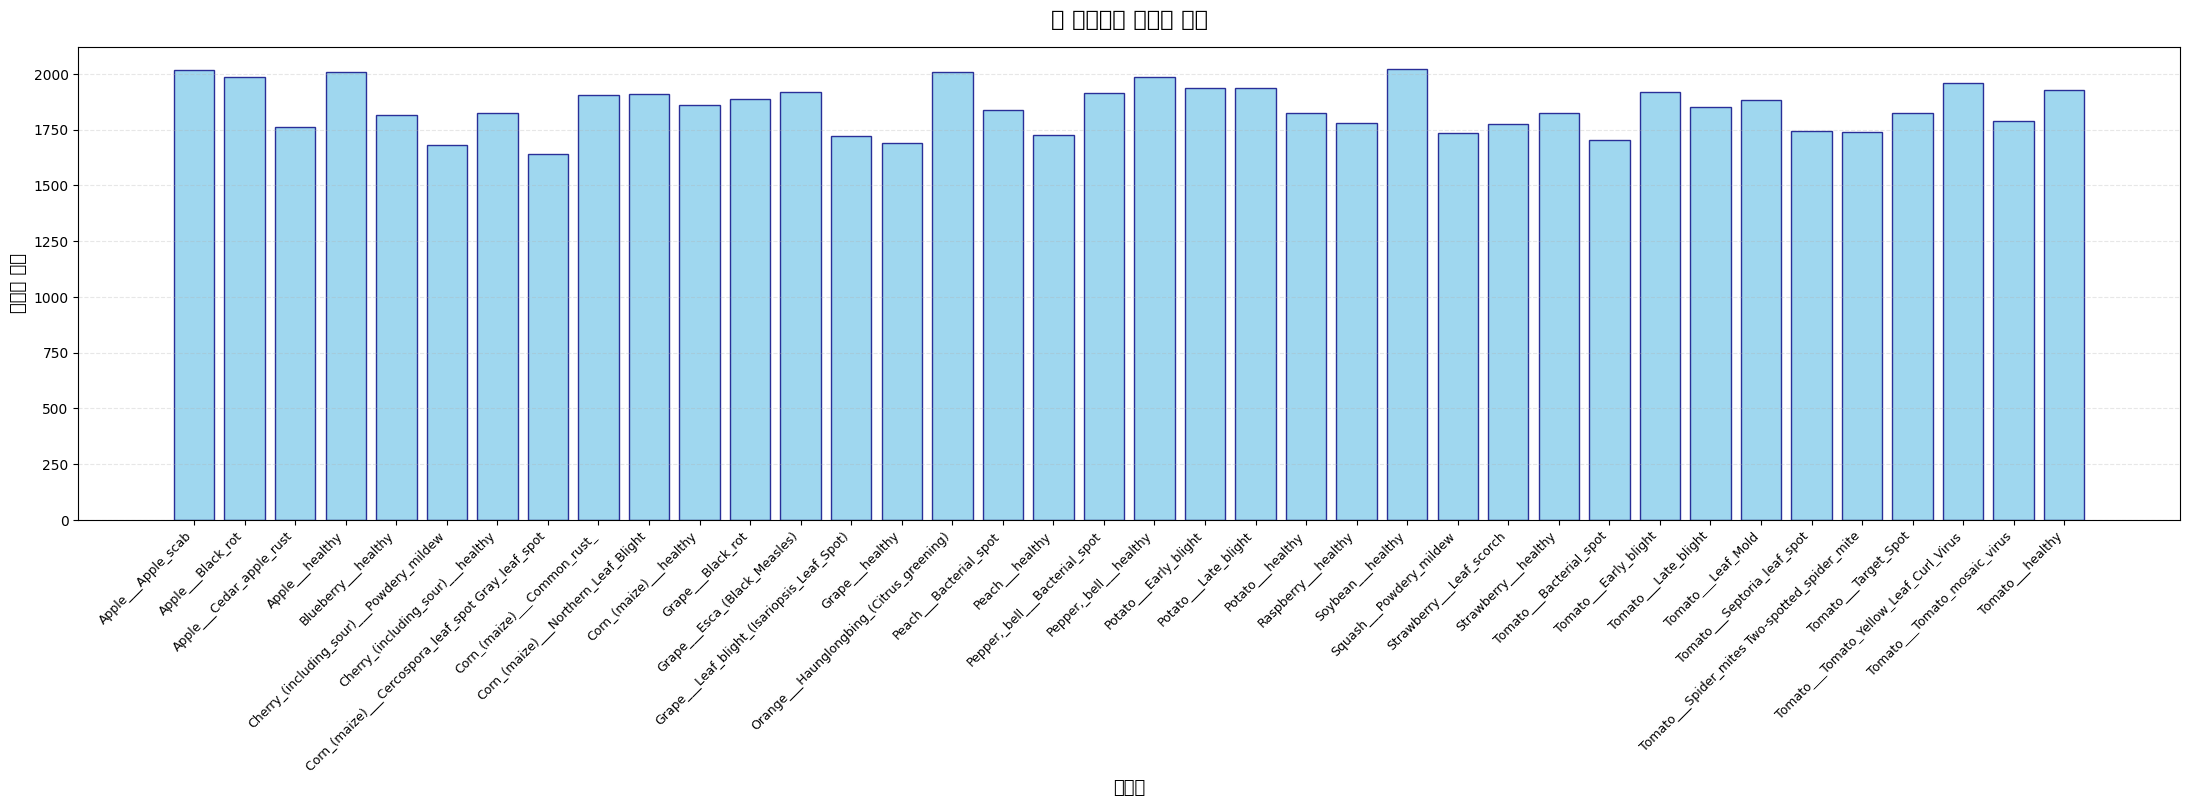

In [ ]:
# ==========================================
# 📊 시각화 1: 클래스별 데이터 분포
# ==========================================
print("\n📊 [시각화] 클래스별 데이터 분포 확인 중...")
class_counts = Counter([full_dataset.targets[i] for i in range(len(full_dataset))])
class_names_sorted = [class_names[i] for i in sorted(class_counts.keys())]
counts_sorted = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(22, 7))
plt.bar(range(len(class_names_sorted)), counts_sorted, color='skyblue', edgecolor='navy', alpha=0.8)
plt.xlabel('클래스', fontsize=13, fontweight='bold')
plt.ylabel('이미지 개수', fontsize=13, fontweight='bold')
plt.title('📊 클래스별 데이터 분포', fontsize=16, fontweight='bold', pad=15)
plt.xticks(range(len(class_names_sorted)), class_names_sorted,
           rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.subplots_adjust(bottom=0.25)  # 하단 여백 확보
plt.show()

In [ ]:
# ==========================================
# 🖼️ 시각화 2: 샘플 이미지 미리보기
# ==========================================
print("\n🖼️ [시각화] 샘플 이미지 미리보기 (클래스별 1장씩)")

def denormalize(tensor):
    """정규화된 텐서를 원래 이미지로 복원"""
    tensor = tensor.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# 각 클래스별로 첫 번째 이미지 가져오기
sample_images = []
sample_labels = []
seen_classes = set()

for img, label in full_dataset:
    if label not in seen_classes:
        sample_images.append(img)
        sample_labels.append(label)
        seen_classes.add(label)
    if len(sample_images) >= 12:  # 12개만 표시
        break

fig, axes = plt.subplots(3, 4, figsize=(16, 13))
axes = axes.flatten()

for idx, (img, label) in enumerate(zip(sample_images, sample_labels)):
    if idx >= 12:
        break
    img_denorm = denormalize(img)
    img_np = img_denorm.permute(1, 2, 0).numpy()

    # 클래스 이름이 너무 길면 줄임
    class_name = class_names[label]
    if len(class_name) > 25:
        class_name = class_name[:22] + '...'

    axes[idx].imshow(img_np)
    axes[idx].set_title(class_name, fontsize=10, fontweight='bold', pad=8)
    axes[idx].axis('off')

plt.suptitle('🖼️ 각 클래스별 샘플 이미지', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
# ==========================================
# 6. MobileNet V2 모델 로드
# ==========================================
print("\n🔄 MobileNet V2 로드 중...")
model = models.mobilenet_v2(pretrained=True)

# Backbone 얼리기
for param in model.parameters():
    param.requires_grad = False

# 분류기 교체
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 기록 저장용
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}



🔄 MobileNet V2 로드 중...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


In [ ]:
# ==========================================
# 7. [1단계] 전이학습 (Transfer Learning)
# ==========================================
print("\n🧊 [1단계] 전이학습 시작 (Backbone Freeze)")
print("="*60)

epochs_stage1 = 10

for epoch in range(epochs_stage1):
    # --- 학습 모드 ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- 검증 모드 ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # 기록 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"[Step 1] Epoch {epoch+1}/{epochs_stage1}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print("-"*60)


🧊 [1단계] 전이학습 시작 (Backbone Freeze)
[Step 1] Epoch 1/10
  Train - Loss: 0.4095, Acc: 89.90%
  Val   - Loss: 0.1462, Acc: 95.77%
------------------------------------------------------------
[Step 1] Epoch 2/10
  Train - Loss: 0.1787, Acc: 94.33%
  Val   - Loss: 0.1124, Acc: 96.50%
------------------------------------------------------------
[Step 1] Epoch 3/10
  Train - Loss: 0.1551, Acc: 94.90%
  Val   - Loss: 0.1012, Acc: 96.67%
------------------------------------------------------------
[Step 1] Epoch 4/10
  Train - Loss: 0.1431, Acc: 95.23%
  Val   - Loss: 0.0880, Acc: 97.11%
------------------------------------------------------------
[Step 1] Epoch 5/10
  Train - Loss: 0.1322, Acc: 95.54%
  Val   - Loss: 0.0991, Acc: 96.64%
------------------------------------------------------------
[Step 1] Epoch 6/10
  Train - Loss: 0.1279, Acc: 95.59%
  Val   - Loss: 0.0772, Acc: 97.31%
------------------------------------------------------------
[Step 1] Epoch 7/10
  Train - Loss: 0.1280, Acc

In [ ]:
# ==========================================
# 8. [2단계] 파인튜닝 (Fine-Tuning)
# ==========================================
print("\n🔥 [2단계] 파인튜닝 시작 (Unfreeze & Low LR)")
print("="*60)

# Backbone 전체 녹이기
for param in model.parameters():
    param.requires_grad = True

# 학습률 1/100로 대폭 낮춤
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs_stage2 = 5  # 5번으로 변경
total_epochs = epochs_stage1 + epochs_stage2

for epoch in range(epochs_stage2):
    # --- 학습 모드 ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # --- 검증 모드 ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # 기록 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"[Step 2] Epoch {epochs_stage1 + epoch + 1}/{total_epochs}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print("-"*60)


🔥 [2단계] 파인튜닝 시작 (Unfreeze & Low LR)
[Step 2] Epoch 11/15
  Train - Loss: 0.0687, Acc: 97.70%
  Val   - Loss: 0.0375, Acc: 98.77%
------------------------------------------------------------
[Step 2] Epoch 12/15
  Train - Loss: 0.0341, Acc: 98.82%
  Val   - Loss: 0.0294, Acc: 99.01%
------------------------------------------------------------
[Step 2] Epoch 13/15
  Train - Loss: 0.0233, Acc: 99.22%
  Val   - Loss: 0.0250, Acc: 99.20%
------------------------------------------------------------
[Step 2] Epoch 14/15
  Train - Loss: 0.0149, Acc: 99.52%
  Val   - Loss: 0.0237, Acc: 99.30%
------------------------------------------------------------
[Step 2] Epoch 15/15
  Train - Loss: 0.0118, Acc: 99.60%
  Val   - Loss: 0.0217, Acc: 99.37%
------------------------------------------------------------



📈 [시각화] 학습 곡선 그래프 생성 중...


/tmp/ipython-input-1222256548.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1222256548.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


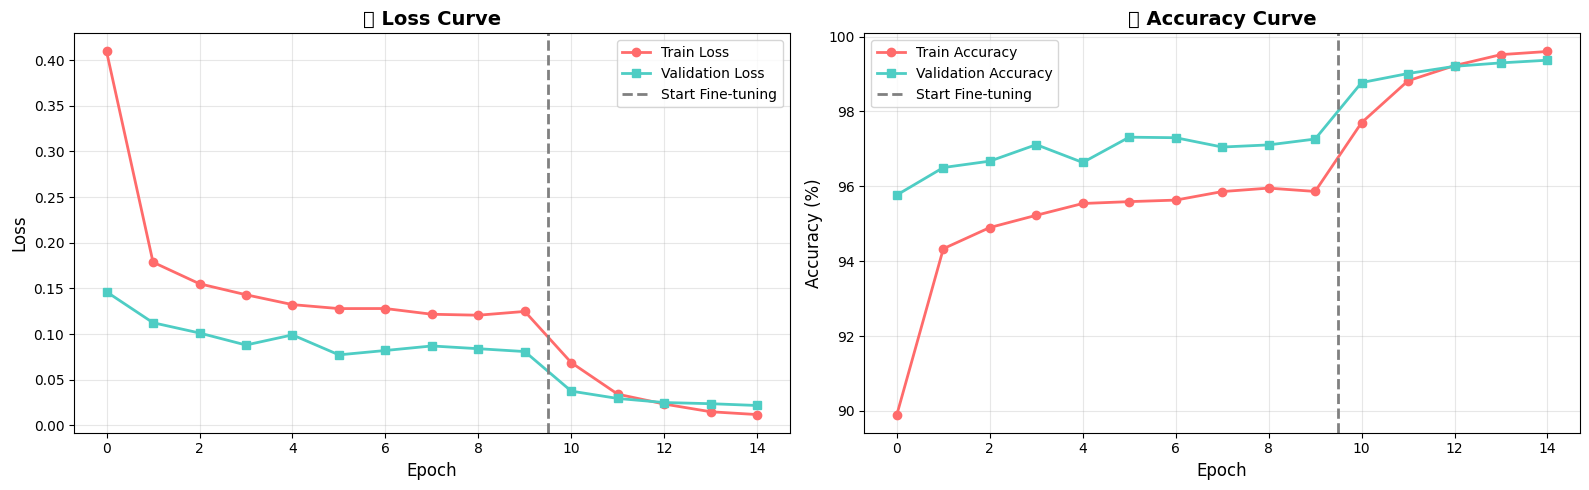

In [ ]:
# ==========================================
# 📈 시각화 3: 학습 곡선 (Loss & Accuracy)
# ==========================================
print("\n📈 [시각화] 학습 곡선 그래프 생성 중...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss 그래프
ax1.plot(history['train_loss'], label='Train Loss', marker='o', color='#FF6B6B', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', marker='s', color='#4ECDC4', linewidth=2)
ax1.axvline(x=epochs_stage1-0.5, color='gray', linestyle='--', linewidth=2, label='Start Fine-tuning')
ax1.set_title('📉 Loss Curve', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy 그래프
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o', color='#FF6B6B', linewidth=2)
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s', color='#4ECDC4', linewidth=2)
ax2.axvline(x=epochs_stage1-0.5, color='gray', linestyle='--', linewidth=2, label='Start Fine-tuning')
ax2.set_title('📈 Accuracy Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 9. 최종 검증 및 평가
# ==========================================
print("\n🎯 [최종 평가] 검증 데이터셋 성능 측정 중...")
model.eval()
correct = 0
total = 0
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

final_acc = 100 * correct / total
print("\n" + "="*60)
print(f"🏆 최종 검증 정확도: {final_acc:.2f}%")
print("="*60)


🎯 [최종 평가] 검증 데이터셋 성능 측정 중...

🏆 최종 검증 정확도: 99.37%



🎯 [시각화] Confusion Matrix 생성 중...


/tmp/ipython-input-3582349399.py:23: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


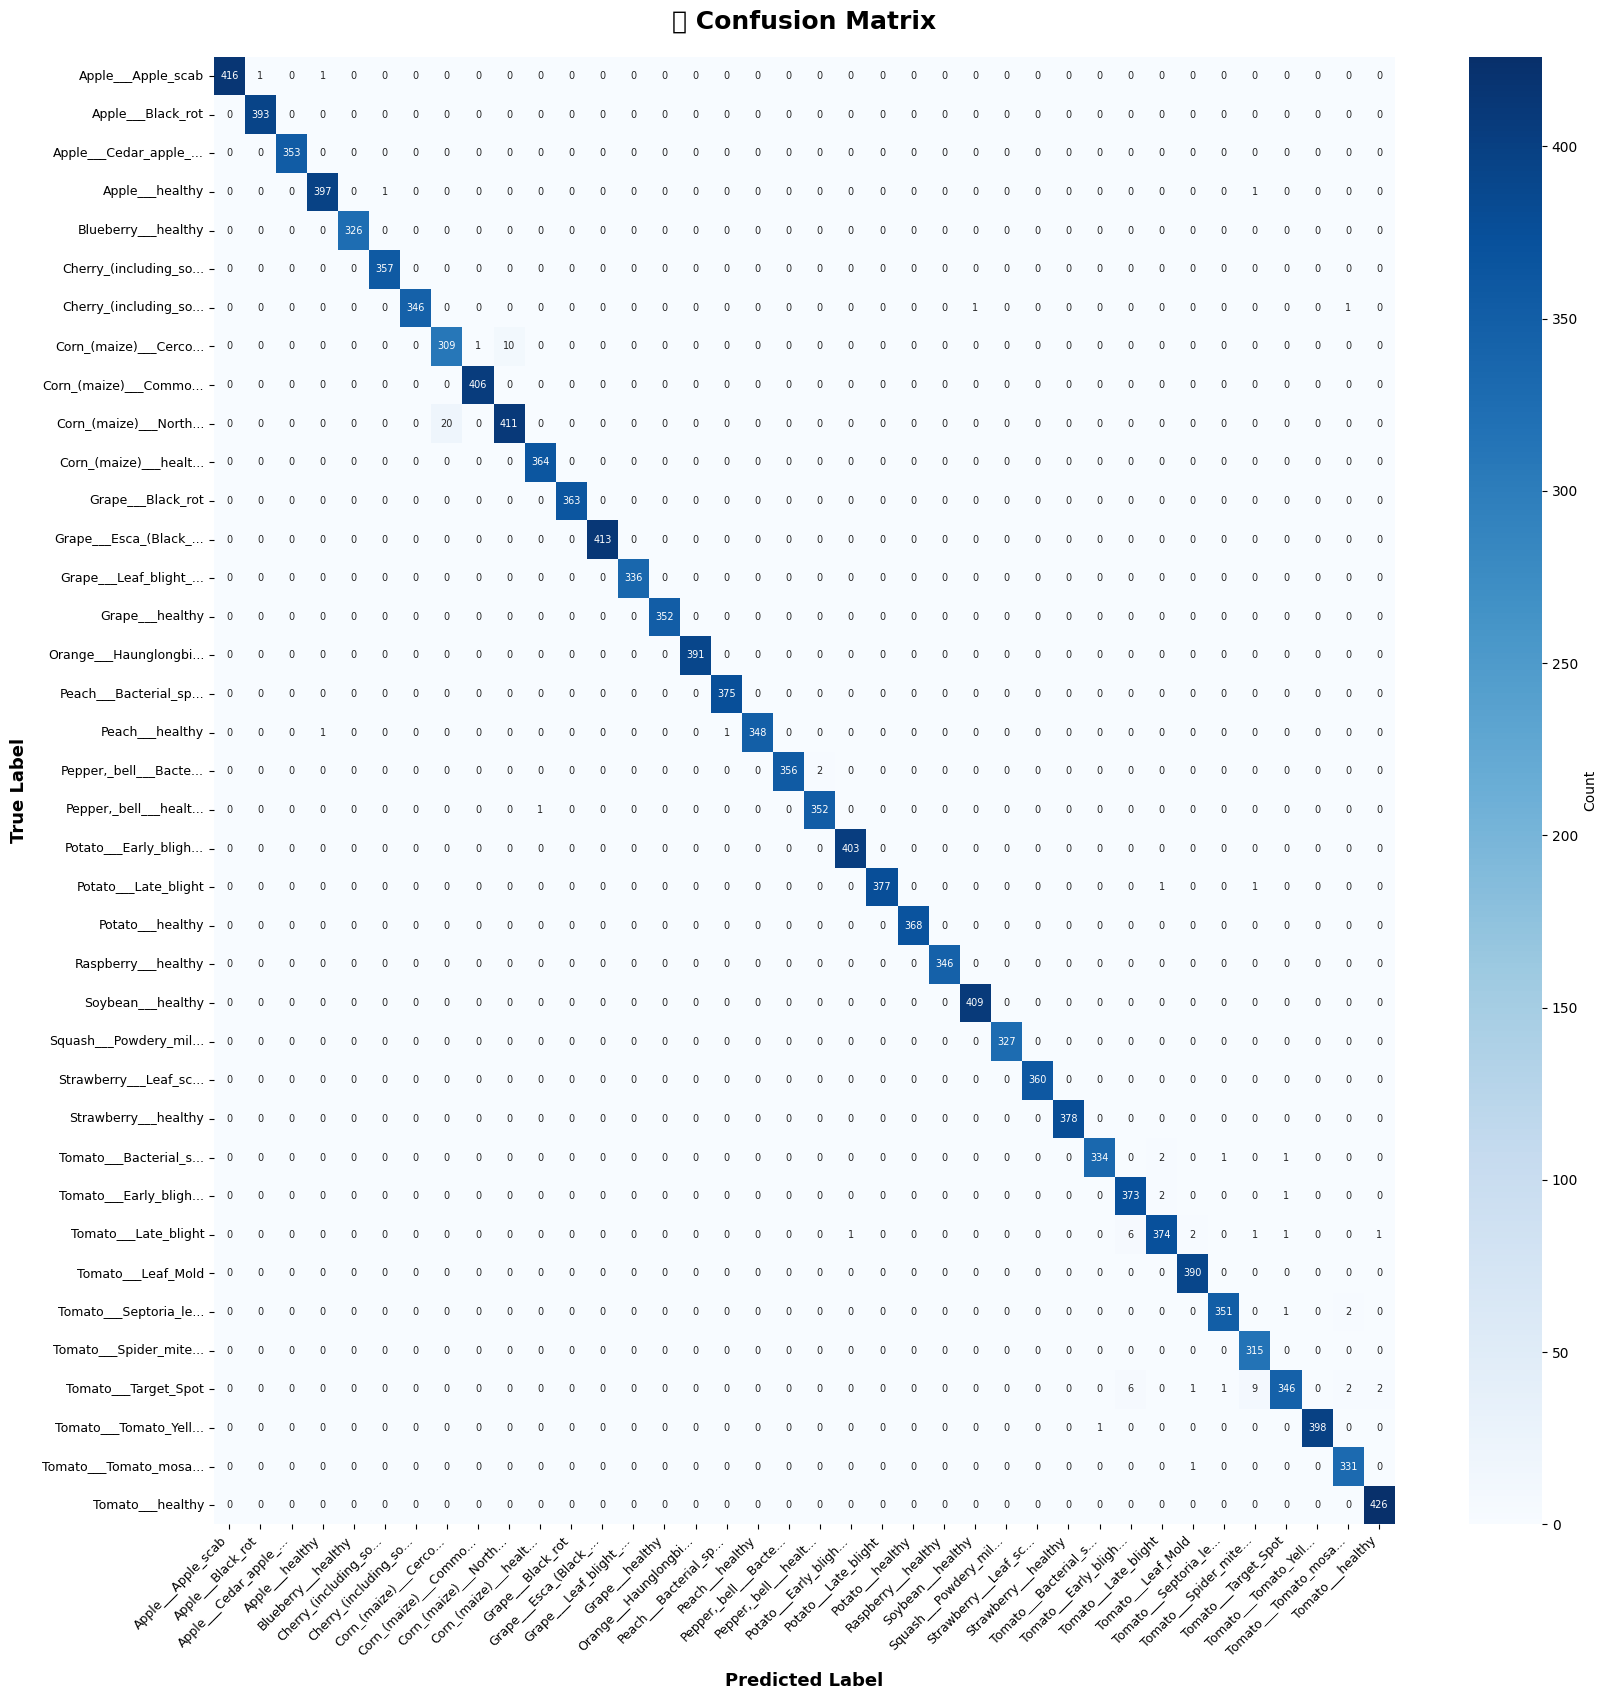

In [ ]:
# ==========================================
# 🎯 시각화 4: Confusion Matrix
# ==========================================
print("\n🎯 [시각화] Confusion Matrix 생성 중...")

cm = confusion_matrix(y_true, y_pred)

# 클래스가 너무 많으면 크기 조정
fig_size = max(14, len(class_names) * 0.45)
plt.figure(figsize=(fig_size, fig_size))

# 클래스 이름이 너무 길면 줄임
class_names_short = [name[:20] + '...' if len(name) > 20 else name for name in class_names]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_short, yticklabels=class_names_short,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 7})
plt.title('🎯 Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel('True Label', fontsize=13, fontweight='bold', labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 📋 분류 리포트 출력
# ==========================================
print("\n📋 [상세 분류 리포트]")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))


📋 [상세 분류 리포트]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       418
                                 Apple___Black_rot       1.00      1.00      1.00       393
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       353
                                   Apple___healthy       0.99      0.99      0.99       399
                               Blueberry___healthy       1.00      1.00      1.00       326
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       357
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       348
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.97      0.95       320
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       406
               Corn_(maize)___Northern_Leaf_Blight       0.98   

In [ ]:
# ==========================================
# 🖼️ 시각화 5: 예측 결과 시각화
# ==========================================
def imshow(inp, title=None, color='black'):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, color=color, fontsize=10, fontweight='bold', pad=5)
    plt.axis('off')

def visualize_predictions(model, num_images=16):
    """모델 예측 결과 시각화"""
    was_training = model.training
    model.eval()

    viz_loader = torch.utils.data.DataLoader(val_dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(viz_loader))

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidences, preds = torch.max(probs, 1)

    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)

        if preds[i] == labels[i]:
            color = 'green'
            result = "✓"
        else:
            color = 'red'
            result = "✗"

        # 클래스 이름이 너무 길면 줄임
        true_name = class_names[labels[i]]
        pred_name = class_names[preds[i]]

        if len(true_name) > 20:
            true_name = true_name[:17] + '...'
        if len(pred_name) > 20:
            pred_name = pred_name[:17] + '...'

        confidence = confidences[i].item() * 100

        title = f"{result} True: {true_name}\nPred: {pred_name}\n({confidence:.1f}%)"
        imshow(images.cpu().data[i], title, color)

    plt.suptitle('🖼️ 모델 예측 결과 (초록=정답, 빨강=오답)',
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

    model.train(mode=was_training)

print("\n🖼️ [시각화] 랜덤 이미지 16장 예측 결과 생성 중...")
visualize_predictions(model)

In [ ]:
# ==========================================
# ✅ 학습 완료
# ==========================================
print("\n" + "="*60)
print("✅ 모든 학습 및 시각화가 완료되었습니다!")
print("="*60)
print(f"📊 총 Epoch: {total_epochs}회")
print(f"   - 1단계 (전이학습): {epochs_stage1}회")
print(f"   - 2단계 (파인튜닝): {epochs_stage2}회")
print(f"🏆 최종 검증 정확도: {final_acc:.2f}%")
print("="*60)


✅ 모든 학습 및 시각화가 완료되었습니다!
📊 총 Epoch: 15회
   - 1단계 (전이학습): 10회
   - 2단계 (파인튜닝): 5회
🏆 최종 검증 정확도: 99.37%
